# Прогнозирование температуры звезд

## Описание проекта

Задача: Построить модель нейронной сети для предсказания температуры звёзд, с показателем RMSE не превышающим 4500:

Описание данных:


1 Признаки:


1.1. Категориальные признаки
* Unnamde: 0 - уникальный идентификатор звезды(аналогичен index)
* Star type - тип звезды
* Star color -цвет звезды на основсе спектрального анализа


1.2  Количественные признаки
* Luminosity(L/Lo) - Светимость звезды относительно Солнца
* Radius(R/Ro) - Радиус звезды относительно радиуса Солнца
* Absolute magnitude(Mv) - Физическая величина хараетеризующая блеск звезды




2 Целевая переменная:
* Temperature (K) - Температура поверхности звезды в кельвинах

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from math import sqrt, ceil
import random

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error


plt.style.use('dark_background')
pd.options.display.float_format = '{:,.5f}'.format 


random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

## Загрузка  и первичный просмотр данных

In [2]:
df = pd.read_csv('/datasets/6_class.csv')

In [3]:
display(df.head(2))
display(df.tail(2))

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.00240,0.17000,16.12000,0,Red
1,1,3042,0.00050,0.15420,16.60000,0,Red


,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
238,238,9235,"404,940.00000","1,112.00000",-11.23000,5,White
239,239,37882,"294,903.00000","1,783.00000",-7.80000,5,Blue


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


In [5]:
df.describe()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type
count,240.00000,240.00000,240.00000,240.00000,240.00000,240.00000
mean,119.50000,"10,497.46250","107,188.36163",237.15778,4.38240,2.50000
std,69.42622,"9,552.42504","179,432.24494",517.15576,10.53251,1.71139
min,0.00000,"1,939.00000",0.00008,0.00840,-11.92000,0.00000
25%,59.75000,"3,344.25000",0.00086,0.10275,-6.23250,1.00000
50%,119.50000,"5,776.00000",0.07050,0.76250,8.31300,2.50000
75%,179.25000,"15,055.50000","198,050.00000",42.75000,13.69750,4.00000
max,239.00000,"40,000.00000","849,420.00000","1,948.50000",20.06000,5.00000


In [6]:
df.isna().sum()

Unnamed: 0                0
Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
dtype: int64

In [7]:
df.duplicated().sum()

0

<AxesSubplot:>

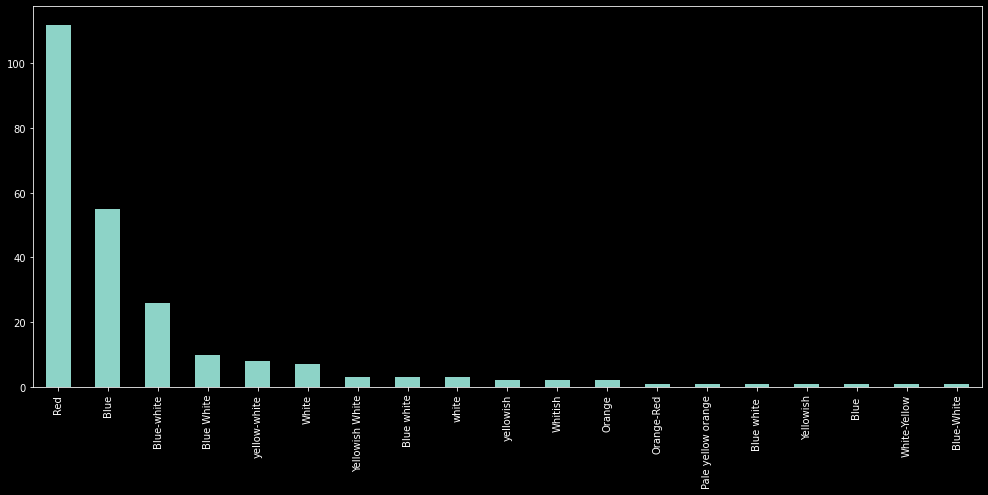

In [8]:
df['Star color'].value_counts().plot(kind = 'bar', figsize = (17,7))

Цвет звезды имеет спектральную зависимотсть от её температуры, поэтому, эквивалентную замену значений числами лучше проводить вручную

### Сводка по первичному осмотру.


* Набор данных включает в себя 240 образцов звезд с признакми различного масштаба и качества.
* В глобальном масштабе пропусков и дубликатов в данных не обнаружено.

## Предобработка и анализ данных

В этой часте будет дана более подробная сводка по каждому определяющему свойству звёзд:

### Изменение названий столбцов

Для удобства дальнейшего манипулирования, с сохранениием смысловой нагрузки

In [9]:
df = df.rename(columns = {'Unnamed: 0': 'unnamed',
                          'Temperature (K)':'temperature',
                         'Luminosity(L/Lo)':'luminosity',
                         'Radius(R/Ro)':'radius',
                         'Absolute magnitude(Mv)':'magnitude',
                         'Star type':'type',
                         'Star color':'color'})

df.columns

Index(['unnamed', 'temperature', 'luminosity', 'radius', 'magnitude', 'type',
       'color'],
      dtype='object')

### Unnamed

Удаление данного столбца обусловлено его полной заместимостью обысным индексом:

In [10]:
df = df.drop(columns = ['unnamed'])

### Luminosity(L/Lo) & Radius(R/Ro)  & Absolute magnitude(Mv)

<AxesSubplot:>

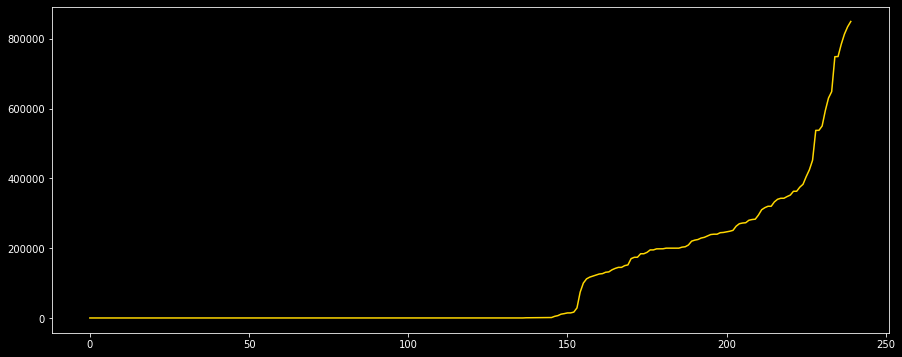

In [11]:
df['luminosity'].sort_values().reset_index(drop = True).plot(color = 'gold', figsize = (15,6))

<AxesSubplot:>

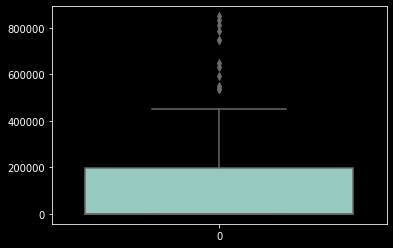

In [12]:
sns.boxplot(data = df['luminosity'])

<AxesSubplot:>

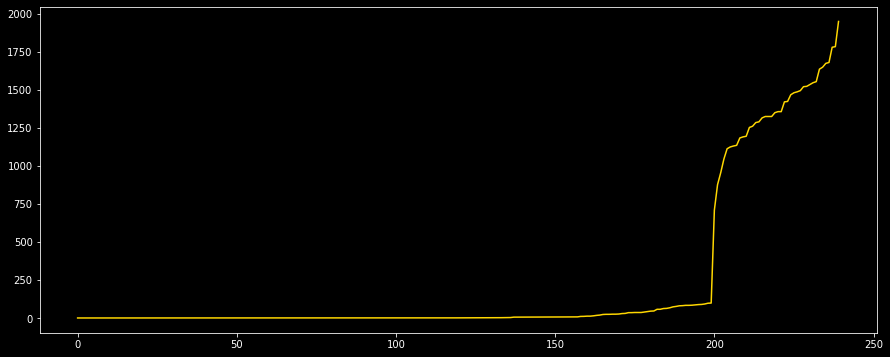

In [13]:
df['radius'].sort_values().reset_index(drop = True).plot(color = 'gold', figsize = (15,6))

<AxesSubplot:>

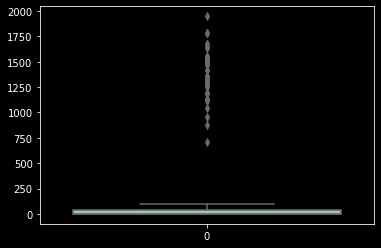

In [14]:
sns.boxplot(data = df['radius'])

<AxesSubplot:>

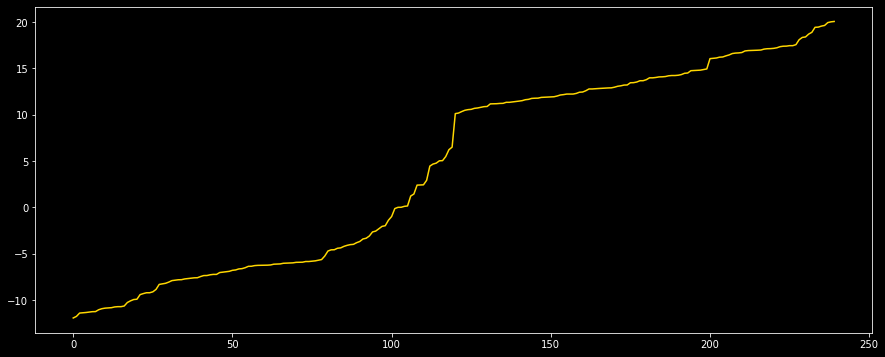

In [15]:
df['magnitude'].sort_values().reset_index(drop = True).plot(color='gold', figsize =(15,6))

<AxesSubplot:>

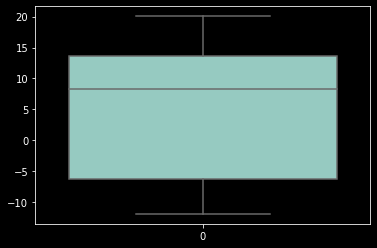

In [16]:
sns.boxplot(data = df['magnitude'])

#### ~~StandartScaler~~

Светимость и яркость значительна только для определенного объема звезд, остальные близятся к солнечной

Количественный разброс между столбцами может помешать адекватно выстраивать значимось между показателями разных столбцов, поэтому -  приведем их к близким разбросам

In [17]:
'''std_col = ['luminosity','radius','magnitude']

sc = StandardScaler()
sc.fit(df[std_col])
df[std_col] = sc.transform(df[std_col])

df[std_col].describe()

'''


"std_col = ['luminosity','radius','magnitude']\n\nsc = StandardScaler()\nsc.fit(df[std_col])\ndf[std_col] = sc.transform(df[std_col])\n\ndf[std_col].describe()\n\n"

### Star type   

<AxesSubplot:>

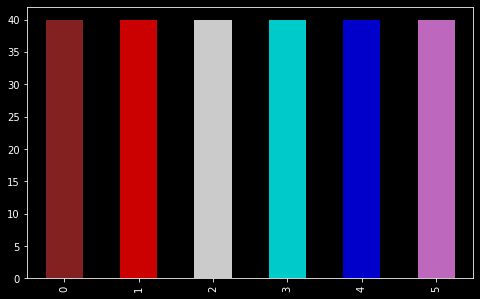

In [18]:
df['type'].value_counts().plot(kind = 'bar', color = ['brown','red','white','cyan','blue','violet'],
                               alpha = 0.8, figsize = (8,5))


#### ~~Трансформация категориальных признаков в числовые~~

In [19]:
'''df_onehot = df.copy()
type_ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False)
df_onehot = pd.DataFrame(type_ohe.fit_transform(df_onehot[['type']]))

df = df.drop(columns = ['type'])
df = df.join(df_onehot, how = 'left')'''

"df_onehot = df.copy()\ntype_ohe = OneHotEncoder(handle_unknown = 'ignore', sparse = False)\ndf_onehot = pd.DataFrame(type_ohe.fit_transform(df_onehot[['type']]))\n\ndf = df.drop(columns = ['type'])\ndf = df.join(df_onehot, how = 'left')"

### Star color 

In [20]:
df['color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

#### Удаление дубликатов и кодирование:

In [21]:
df['color'] = df['color'].str.strip(' ')
df['color'] = df['color'].str.lower()
df['color'] = df['color'].str.replace('-','')
df['color'] = df['color'].str.replace(' ','')
df['color'].value_counts()

red                 112
blue                 56
bluewhite            41
white                10
yellowwhite           8
yellowishwhite        3
yellowish             3
orange                2
whitish               2
orangered             1
whiteyellow           1
paleyelloworange      1
Name: color, dtype: int64

<AxesSubplot:>

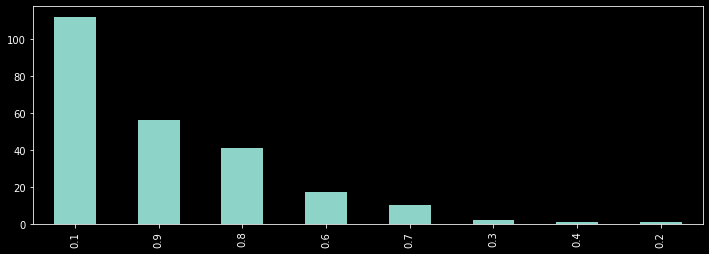

In [22]:
df = df.replace({'color':{'red':0.1,'orangered':0.2,
                           'orange':0.3,'paleyelloworange':0.4,
                           'yellow':0.5,'yellowwhite':0.6,
                          'yellowishwhite':0.6,'yellowish':0.6,
                          'whiteyellow':0.6,'whitish':0.6,'white':0.7,
                          'bluewhite':0.8,'blue':0.9}})

df['color'].value_counts().plot(kind = 'bar',figsize = (12,4))

### Разбиение на выборки:

In [23]:
Y = df['temperature']
X = df.drop(columns = ['temperature'])

x_train, x_test, y_train, y_test = train_test_split(X,Y,
                                                    test_size = 0.25,
                                                    shuffle = True,
                                                    random_state = 1667)

### **Стандартизация и кодирование переменных:**

#### **StandardScaler**

**Приведение значений Luminosity, Radius, Absolute magnitude к близкому друг к другу разбросу значений**

In [24]:
std_col = ['luminosity','radius','magnitude']

* Обучение и преобразование на тренировочной выборке

In [25]:
sc = StandardScaler()
sc.fit(x_train[std_col])
x_train[std_col] = sc.transform(x_train[std_col])

x_train.describe()

/tmp/ipykernel_107/1170013715.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_train[std_col] = sc.transform(x_train[std_col])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,luminosity,radius,magnitude,type,color
count,180.00000,180.00000,180.00000,180.00000,180.00000
mean,0.00000,0.00000,-0.00000,2.53333,0.49611
std,1.00279,1.00279,1.00279,1.65249,0.36254
min,-0.60025,-0.44275,-1.55946,0.00000,0.10000
25%,-0.60025,-0.44254,-0.99508,1.00000,0.10000
50%,-0.60025,-0.44096,0.17960,3.00000,0.60000
75%,0.53078,-0.37076,0.87277,4.00000,0.90000
max,4.25065,3.19111,1.54052,5.00000,0.90000


* Трансформация тестовой выборки 

In [26]:
x_test[std_col] = sc.transform(x_test[std_col])
x_test.describe()

/tmp/ipykernel_107/2492768391.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test[std_col] = sc.transform(x_test[std_col])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,luminosity,radius,magnitude,type,color
count,60.00000,60.00000,60.00000,60.00000,60.00000
mean,0.04753,0.16666,0.09116,2.40000,0.39167
std,1.09587,1.20349,1.08438,1.88841,0.34655
min,-0.60025,-0.44275,-1.50511,0.00000,0.10000
25%,-0.60025,-0.44257,-1.06544,0.75000,0.10000
50%,-0.60025,-0.44166,0.65245,2.00000,0.10000
75%,0.52050,-0.27731,1.07440,4.00000,0.80000
max,3.67425,3.53734,1.54440,5.00000,0.90000


#### **OneHotEncoder**

**Трансформация категориальных значений Типа звезды в бинарно-строчные:**

* Обучени и преобразование тренировочной выборки:

In [27]:

x_train_index = x_train.index
x_onehot = x_train.copy()
type_ohe = OneHotEncoder(handle_unknown = 'ignore',sparse = False)
x_onehot = pd.DataFrame(type_ohe.fit_transform(x_onehot[['type']]), index = x_train_index)



x_train = x_train.drop(columns = ['type'])
x_train = x_train.join(x_onehot, how = 'left')

* Трансформация тестовой выборки:

In [28]:
x_test_index = x_test.index

xt_onehot = x_test.copy()
xt_onehot = pd.DataFrame(type_ohe.transform(xt_onehot[['type']]), index = x_test_index)

x_test = x_test.drop(columns = ['type'])
x_test = x_test.join(xt_onehot, how = 'left')

### Итоги предобработки

Вывод по локальной обработке столбцов:

* Данные были преведены в близкие друг к другу масштабы.
* Категориальные данные изменены в эквивалентные количественные или числовые-бинарные коэффиценты
* Размножение данных, или агументация не видится желательной ввиду сложности понимания зависимых характеристик.

## Построение базовой нейронной сети

In [29]:
# сохраняем индексы предиктов
y_idx = y_test.index

In [30]:
# Напишем функцию, которя будет выводить предсказанную температуру и установленную учеными

def compar(test_preds,y_test,y_idx = y_idx):
    t = [int(x) for x in list(test_preds.detach().numpy())]
    y = [int(x) for x in list(y_test.detach().numpy())]
    new_df = {'predict':t,'true':y}
    dd = pd.DataFrame(data = new_df, index = y_idx)
    dd[0:31].plot(kind = 'bar', figsize = (16,10), color = ['gold','white'], alpha = 0.8)
    dd[31:61].plot(kind = 'bar', figsize = (16,10), color = ['gold','white'], alpha = 0.8)
    

In [31]:
# Превращение выборок в тензоры

x_train = torch.FloatTensor(x_train.values)
x_test = torch.FloatTensor(x_test.values)
y_train = torch.FloatTensor(y_train.values)
y_test = torch.FloatTensor(y_test.values)

### Нейронная сеть:

Путем подбора архитектурных решений выведем наиболее успешный вариант нейронной сети и лучшией результат её рабоыт:

**Наследование nn.Module**

Step 0: 11384.794069283818
Step 200: 4028.4350559491463
Step 400: 3463.4211410107205
Step 600: 3216.351659878005
Step 800: 3228.4050241566656
Step 1000: 3232.360283136767
Step 1200: 3270.1666624195163
Step 1400: 3486.6217173648192
Step 1600: 3556.348689316052
Step 1800: 3721.6181964301495
Step 1999: 4047.5378935841973
top rmse: 3088.9784719223926 
 top epoch: 1045


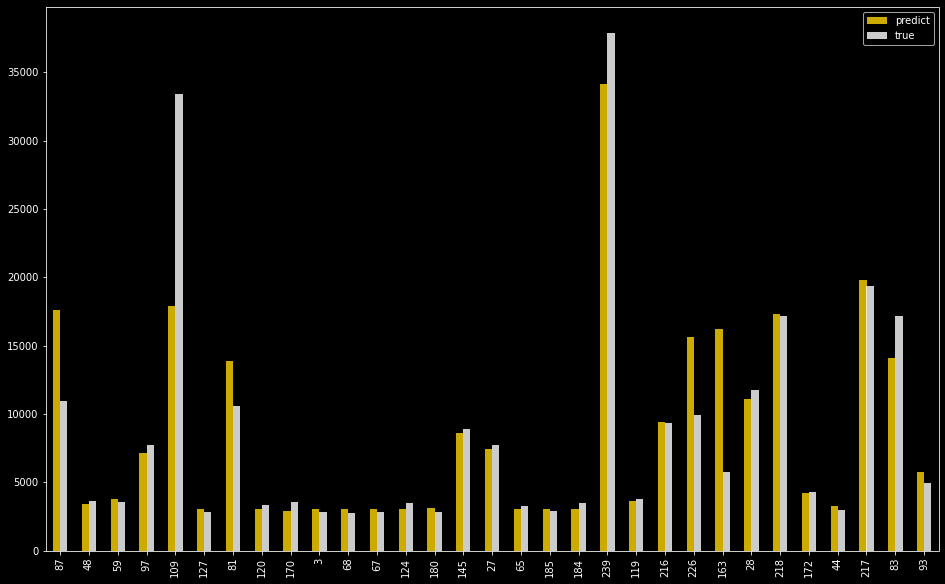

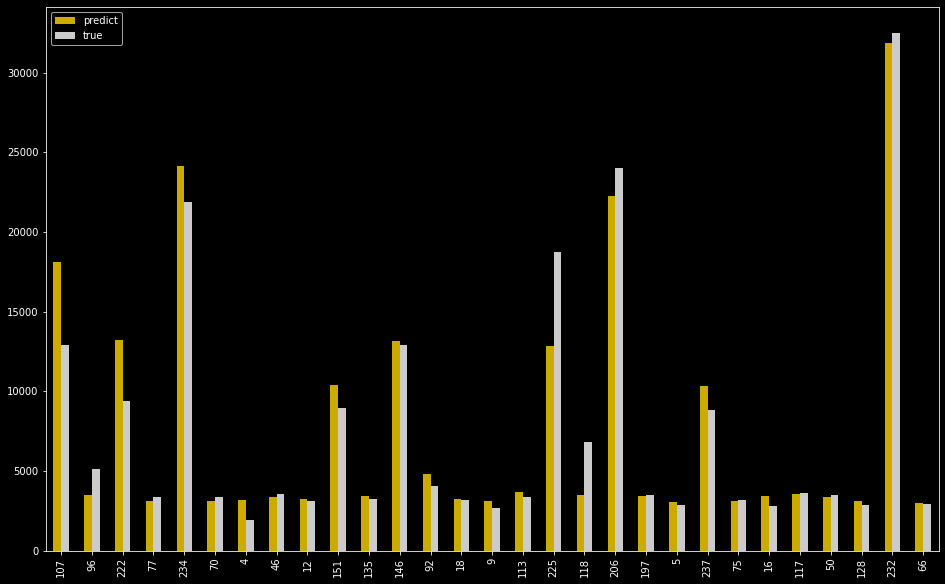

In [32]:
class Net(nn.Module):
    def __init__(self,n_in_neurons,n_hidden_neurons_1,
                n_hidden_neurons_2,n_hidden_neurons_3, n_out_neurons):
        super(Net,self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1,n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        
        self.fc3 = nn.Linear(n_hidden_neurons_2,n_hidden_neurons_3)
        self.act3 = nn.ReLU()
        
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)
        
        nn.init.kaiming_uniform_(self.fc1.weight, mode = 'fan_out', nonlinearity = 'relu')
        nn.init.uniform_(self.fc1.bias, a = 0.5, b=  0.7)
        
        nn.init.kaiming_uniform_(self.fc2.weight, mode = 'fan_out', nonlinearity = 'relu')
        nn.init.uniform_(self.fc2.bias, a = 0.5, b =0.7)
        
        nn.init.kaiming_uniform_(self.fc3.weight, mode = 'fan_out', nonlinearity = 'relu')
        nn.init.uniform_(self.fc3.bias, a = 0.5, b = 0.7)
        
        nn.init.uniform_(self.fc4.weight, a = 0.5 ,b= 0.7)
        nn.init.uniform_(self.fc4.bias, a = 0.5 , b = 0.7)
    
    def forward(self,x):
        x = self.fc1(x)
        x = self.act1(x)
        
        x = self.fc2(x)
        x = self.act2(x)
        
        x = self.fc3(x)
        x = self.act3(x)
        
        x = self.fc4(x)
        
        return x
        

n_in_neurons = 10
n_hidden_neurons_1 = 24
n_hidden_neurons_2 = 12
n_hidden_neurons_3 = 6
n_out_neurons = 1

net = Net(10,24,12,6,1)

optimizer = torch.optim.Adam(net.parameters(), lr = 0.10 )

loss = nn.MSELoss()

num_epochs = 2000

top_rmse_1 = 150000
top_epoch_1 = None
top_preds_1 = None

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    preds = net.forward(x_train).flatten()
    
    loss_value = loss(preds, y_train)
    
    loss_value.backward()
    
    optimizer.step()
    
    if epoch % 5 == 0 or epoch == num_epochs -1:
        net.eval()
        test_preds = net.forward(x_test)
        train_preds = net.forward(x_train)
        rmse = sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy()))
        rmse_train = sqrt(mean_squared_error(y_train.detach().numpy(), train_preds.detach().numpy()))
        if rmse < top_rmse_1:
            top_rmse_1 = rmse
            top_epoch_1 = epoch
            top_preds_1 = test_preds
    if epoch % 200 == 0 or epoch == num_epochs -1:
        print(f'Step {epoch}:',rmse)
        
    
print(f'top rmse: {top_rmse_1}','\n'
         , f'top epoch: {top_epoch_1}')
compar(top_preds_1, y_test, y_idx)

Нейронная сеть на лучшей итерации(1045) выдает точность в 3088 RMSE, что соответствует запрашиваемой точности - менее 4500RMSE, по условию.

Проведем дальнейшее тестирование возможных улучшений нейронной сети, чтобы построить наилучшую модель.

## Улучшение нейронной сети

Ориентуриуясь на пододобранную архитектуру, постараемся улучшит нашу нейронную сеть следующими решениями:

* Обучение с помощью выброрк, с изменением размера и batch_normalization
 
* dropout




### Batch Normalization

Первый тест улучшения полученной нейронной сети проведем с помощью разбиения исходной выборке на батчи, и их нормализацию:

Batch_size:5 Epoch:0 RMSE: 11305.196681172778
Batch_size:5 Epoch:200 RMSE: 4719.811648784303
Batch_size:5 Epoch:400 RMSE: 4691.01289701915
Batch_size:5 Epoch:600 RMSE: 5060.930349253978
Batch_size:5 Epoch:800 RMSE: 4773.618124651363
Batch_size:5 Epoch:1000 RMSE: 4517.81407319956
Batch_size:5 Epoch:1200 RMSE: 4675.859279319685
Batch_size:5 Epoch:1400 RMSE: 5516.317612320741
Batch_size:5 Epoch:1600 RMSE: 4670.567203242022
Batch_size:5 Epoch:1800 RMSE: 4446.585881325132
Batch_size:5 Epoch:1999 RMSE: 4318.490708569372
Batch_size:10 Epoch:0 RMSE: 4494.582516763932
Batch_size:10 Epoch:200 RMSE: 4691.411301516848
Batch_size:10 Epoch:400 RMSE: 4894.482812310203
Batch_size:10 Epoch:600 RMSE: 4281.512116063669
Batch_size:10 Epoch:800 RMSE: 3950.955327512575
Batch_size:10 Epoch:1000 RMSE: 4209.064266556166
Batch_size:10 Epoch:1200 RMSE: 4056.098618130481
Batch_size:10 Epoch:1400 RMSE: 4740.570851701301
Batch_size:10 Epoch:1600 RMSE: 4731.861156035751
Batch_size:10 Epoch:1800 RMSE: 4220.8764492697

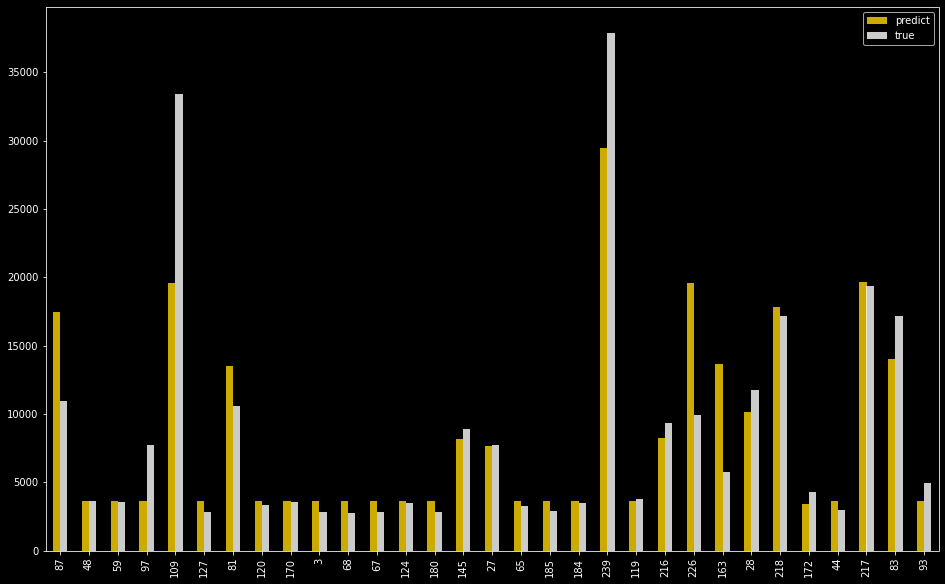

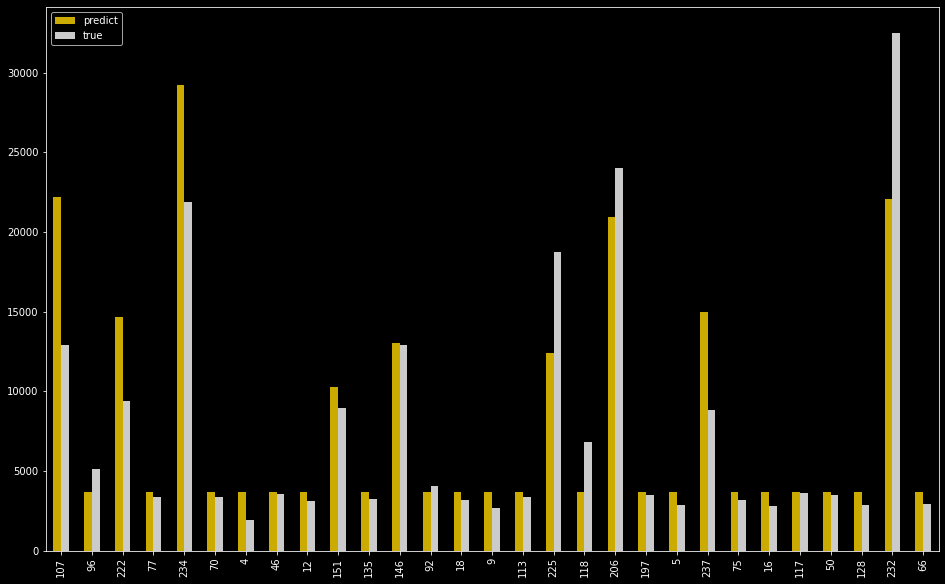

In [33]:
class Net(nn.Module):
    def __init__(self,n_in_neurons,n_hidden_neurons_1,
                n_hidden_neurons_2,n_hidden_neurons_3,n_out_neurons):
        super(Net,self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
        
        self.fc2 = nn.Linear(n_hidden_neurons_1,n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
        
        self.fc3 = nn.Linear(n_hidden_neurons_2,n_hidden_neurons_3)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm1d(n_hidden_neurons_3)
        
        self.fc4 = nn.Linear(n_hidden_neurons_3,n_out_neurons)

        
        nn.init.kaiming_uniform_(self.fc1.weight, mode = 'fan_out', nonlinearity = 'relu')
        nn.init.uniform_(self.fc1.bias, a = 0.5, b = 0.7)
        
        nn.init.kaiming_uniform_(self.fc2.weight, mode = 'fan_out', nonlinearity = 'relu')
        nn.init.uniform_(self.fc2.bias, a = 0.5, b = 0.7)
        
        nn.init.kaiming_uniform_(self.fc3.weight, mode = 'fan_out', nonlinearity = 'relu')
        nn.init.uniform_(self.fc3.bias, a = 0.5, b = 0.7)
        
        nn.init.uniform_(self.fc4.weight, a = 0.5, b = 0.7)
        nn.init.uniform_(self.fc4.bias, a = 0.5, b = 0.7)
    
    def forward(self,x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.act2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = self.act3(x)
        
        x = self.fc4(x)
        
        
        return x
        

n_in_neurons = 10
n_hidden_neurons_1 = 24
n_hidden_neurons_2 = 12
n_hidden_neurons_3 = 6
n_out_neurons = 1

net = Net(10,24,12,6,1)

optimizer = torch.optim.Adam(net.parameters(), lr = 0.10)

loss = nn.MSELoss()

num_epochs = 2000

batch_size = [5,10,20,40,50,100]


top_rmse_2 = 150000
top_epoch_2 = None
top_batch_size_2 = None
top_preds_2 = None

for btch in batch_size:
    
    num_batches = ceil(len(x_train)/btch)
    for epoch in range(num_epochs):
        
        order = np.random.permutation(len(x_train))
        
        for batch_idx in range(num_batches):
            start_index = batch_idx * btch
            optimizer.zero_grad()
            batch_indexes = order[start_index:start_index + btch]
            x_batch = x_train[batch_indexes]
            y_batch = y_train[batch_indexes]
            preds = net.forward(x_batch).flatten()
            loss_value = loss(preds, y_batch)
            loss_value.backward()
            optimizer.step()
        if epoch % 5 == 0 or epoch == num_epochs -1:
            net.eval()
            test_preds = net.forward(x_test)
            rmse = sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy()))
        if epoch % 200 == 0 or epoch == num_epochs -1:
            print(f'Batch_size:{btch} Epoch:{epoch} RMSE: {rmse}')
        if rmse < top_rmse_2:
                top_rmse_2 = rmse
                top_epoch_2 = epoch
                top_batch_size_2 = btch
                top_preds_2 =test_preds
                
print(f'top rmse: {top_rmse_2}','\n'
             , f'top epoch: {top_epoch_2}',
     f'top batch_size:{top_batch_size_2}')
compar(top_preds_2, y_test, y_idx)

Вероятно, выборки плохо работают на таких ограниченных объемах данных, как и BatchNormalization. Возможны лучшие решения с использованием bootstrap

### Dropout

Во втором тесте попробуем разлизные варианты отключения нейронов:

Step: 0, Drop: [0.2, 0.4, 0.5], RMSE: 11385.440175944012
Step: 200, Drop: [0.2, 0.4, 0.5], RMSE: 4834.714055660376
Step: 400, Drop: [0.2, 0.4, 0.5], RMSE: 4405.738984551854
Step: 600, Drop: [0.2, 0.4, 0.5], RMSE: 3995.814059738015
Step: 800, Drop: [0.2, 0.4, 0.5], RMSE: 3303.1653001325863
Step: 1000, Drop: [0.2, 0.4, 0.5], RMSE: 3351.001790509817
Step: 1200, Drop: [0.2, 0.4, 0.5], RMSE: 3648.4192467423477
Step: 1400, Drop: [0.2, 0.4, 0.5], RMSE: 4444.533046339064
Step: 1600, Drop: [0.2, 0.4, 0.5], RMSE: 4800.522054943608
Step: 1800, Drop: [0.2, 0.4, 0.5], RMSE: 4770.53519010184
Step: 1999, Drop: [0.2, 0.4, 0.5], RMSE: 4941.148247118274
Step: 0, Drop: [0.4, 0.6, 0.8], RMSE: 11382.771542994264
Step: 200, Drop: [0.4, 0.6, 0.8], RMSE: 4787.269158925576
Step: 400, Drop: [0.4, 0.6, 0.8], RMSE: 4312.766397568967
Step: 600, Drop: [0.4, 0.6, 0.8], RMSE: 3566.737164412315
Step: 800, Drop: [0.4, 0.6, 0.8], RMSE: 3207.4125085495316
Step: 1000, Drop: [0.4, 0.6, 0.8], RMSE: 3260.2860303967195
Step: 

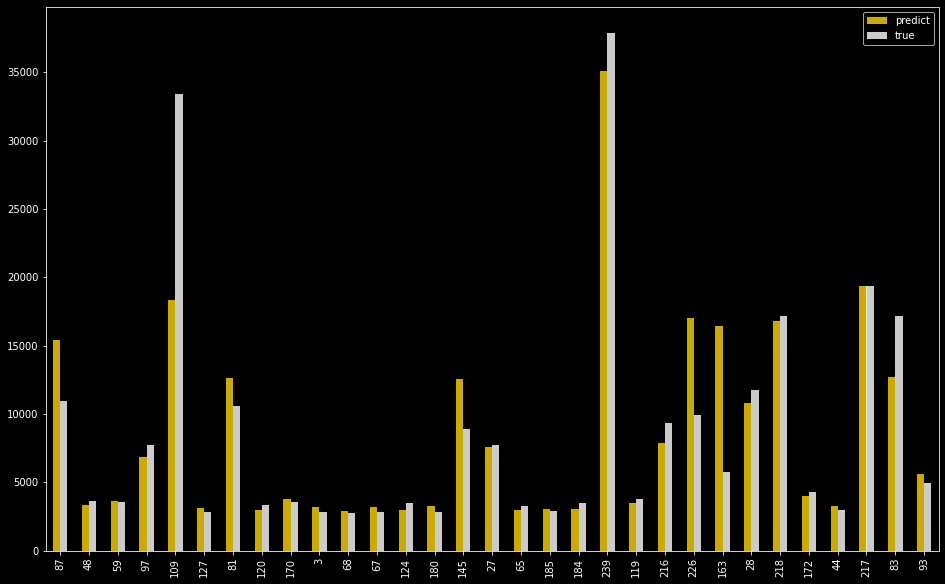

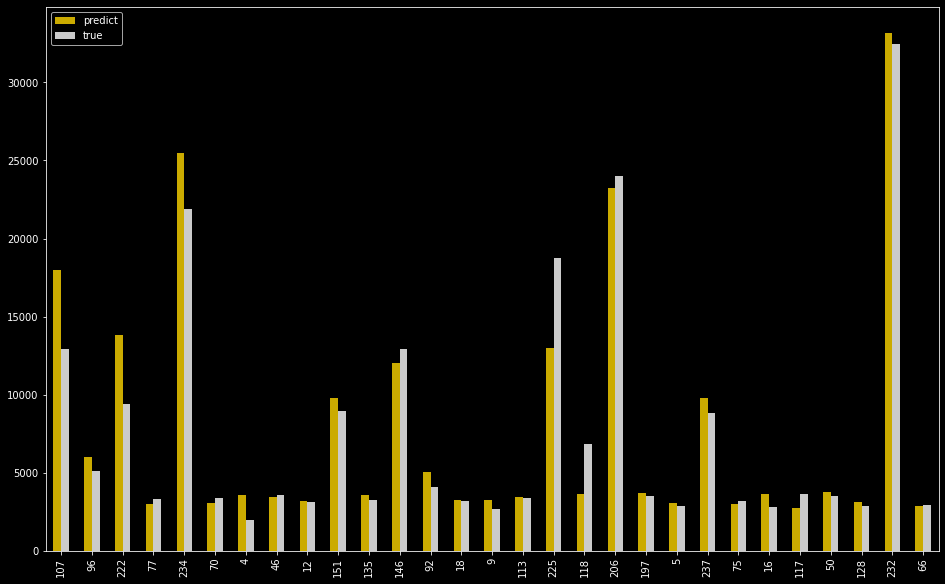

In [34]:
cntnrn = [[0.2,0.4,0.5],[0.4,0.6,0.8],[0.6,0.7,0.8],[0.5,0.5,0],[0.2,0,0.2]]


top_cntnrn_3 = None
top_epoch_3 = None
top_rmse_3 = 150000
top_preds_3 = None


for dnc in cntnrn:
    class Net(nn.Module):
        def __init__(self,n_in_neurons,n_hidden_neurons_1,
                    n_hidden_neurons_2,n_hidden_neurons_3,n_out_neurons):
            super(Net,self).__init__()

            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.dp1 = nn.Dropout(p= dnc[0])

            self.fc2 = nn.Linear(n_hidden_neurons_1,n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            self.dp2 = nn.Dropout(p = dnc[1])

            self.fc3 = nn.Linear(n_hidden_neurons_2,n_hidden_neurons_3)
            self.act3 = nn.ReLU()
            self.dp3 = nn.Dropout(p = dnc[2])

            self.fc4 = nn.Linear(n_hidden_neurons_3,n_out_neurons)

            nn.init.kaiming_uniform_(self.fc1.weight, mode = 'fan_out', nonlinearity = 'relu')
            nn.init.uniform_(self.fc1.bias, a = 0.5, b = 0.7)


            nn.init.kaiming_uniform_(self.fc2.weight, mode = 'fan_out', nonlinearity = 'relu')
            nn.init.uniform_(self.fc2.bias, a = 0.5, b = 0.7)

            nn.init.kaiming_uniform_(self.fc3.weight, mode = 'fan_out', nonlinearity = 'relu')
            nn.init.uniform_(self.fc3.bias, a = 0.5, b = 0.7)

            nn.init.uniform_(self.fc4.weight, a = 0.5, b = 0.7)
            nn.init.uniform_(self.fc4.bias, a = 0.5, b = 0.7)

        def forward(self,x):

            x = self.fc1(x)
            x = self.act1(x)
            x = self.dp1(x)

            x = self.fc2(x)
            x = self.act2(x)
            x = self.dp2(x)

            x = self.fc3(x)
            x = self.act3(x)
            x = self.dp3(x)

            x = self.fc4(x)



            return x


    n_in_neurons = 10
    n_hidden_neurons_1 = 24
    n_hidden_neurons_2 = 12
    n_hidden_neurons_3 = 6
    n_out_neurons = 1

    net = Net(10,24,12,6,1)

    optimizer = torch.optim.Adam(net.parameters(), lr = 0.10 )

    loss = nn.MSELoss()

    num_epochs = 2000

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        preds = net.forward(x_train).flatten()

        loss_value = loss(preds, y_train)

        loss_value.backward()

        optimizer.step()

        if epoch % 5 == 0 or epoch == num_epochs -1:
            net.eval()
            test_preds = net.forward(x_test)
            rmse = sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy()))
            if rmse < top_rmse_3:
                top_rmse_3 = rmse
                top_epoch_3 = epoch
                top_preds_3 = test_preds
                top_cntnrn_3 = dnc
        if epoch % 200 == 0 or epoch == num_epochs -1:
            print(f'Step: {epoch}, Drop: {dnc}, RMSE:',rmse)


print(f'top rmse: {top_rmse_3}','\n'
             , f'top epoch: {top_epoch_3}','\n',
     f'top drop {top_cntnrn_3}')
compar(top_preds_3, y_test, y_idx)

Dropout в конкретном примере справился лучше обучения по батчам и базовой архитектуры уменьшив RMSE на 600 пунктов.

### Dropout & Batch Normalization

Объединим Dropout & Batch Normalization:

Step: 0, Drop: [0.2, 0.4, 0.5], batch: 5 ,RMSE: 11305.918096289217
Step: 200, Drop: [0.2, 0.4, 0.5], batch: 5 ,RMSE: 4383.05555520347
Step: 400, Drop: [0.2, 0.4, 0.5], batch: 5 ,RMSE: 4017.785833017982
Step: 600, Drop: [0.2, 0.4, 0.5], batch: 5 ,RMSE: 3849.1275634876015
Step: 800, Drop: [0.2, 0.4, 0.5], batch: 5 ,RMSE: 4103.689315725546
Step: 1000, Drop: [0.2, 0.4, 0.5], batch: 5 ,RMSE: 3741.2516622114586
Step: 1200, Drop: [0.2, 0.4, 0.5], batch: 5 ,RMSE: 6892.399291973732
Step: 1400, Drop: [0.2, 0.4, 0.5], batch: 5 ,RMSE: 4684.38085556672
Step: 1600, Drop: [0.2, 0.4, 0.5], batch: 5 ,RMSE: 4495.7037268930435
Step: 1800, Drop: [0.2, 0.4, 0.5], batch: 5 ,RMSE: 3827.285199720554
Step: 1999, Drop: [0.2, 0.4, 0.5], batch: 5 ,RMSE: 3734.22307849973
Step: 0, Drop: [0.2, 0.4, 0.5], batch: 10 ,RMSE: 3739.758414657289
Step: 200, Drop: [0.2, 0.4, 0.5], batch: 10 ,RMSE: 3711.7110609528863
Step: 400, Drop: [0.2, 0.4, 0.5], batch: 10 ,RMSE: 6425.122255646191
Step: 600, Drop: [0.2, 0.4, 0.5], batch: 

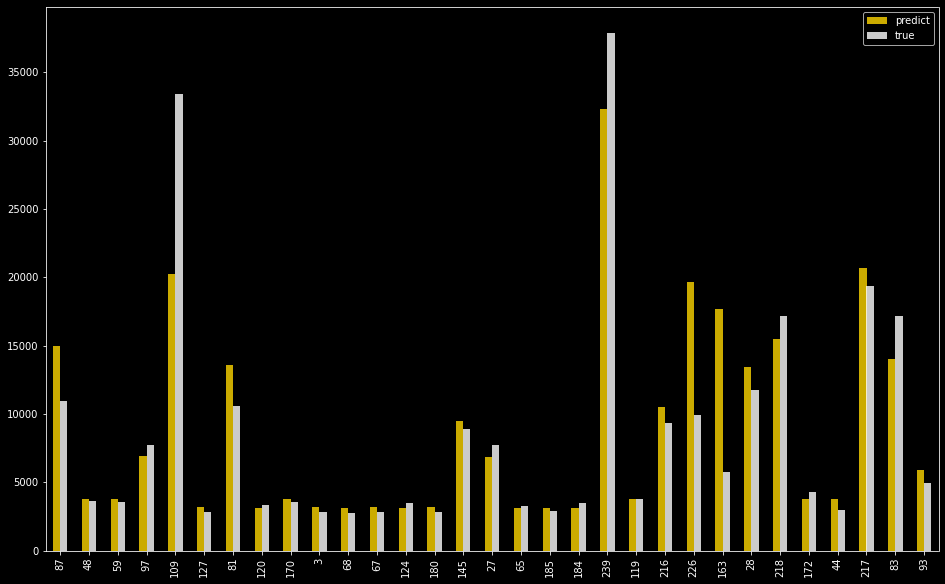

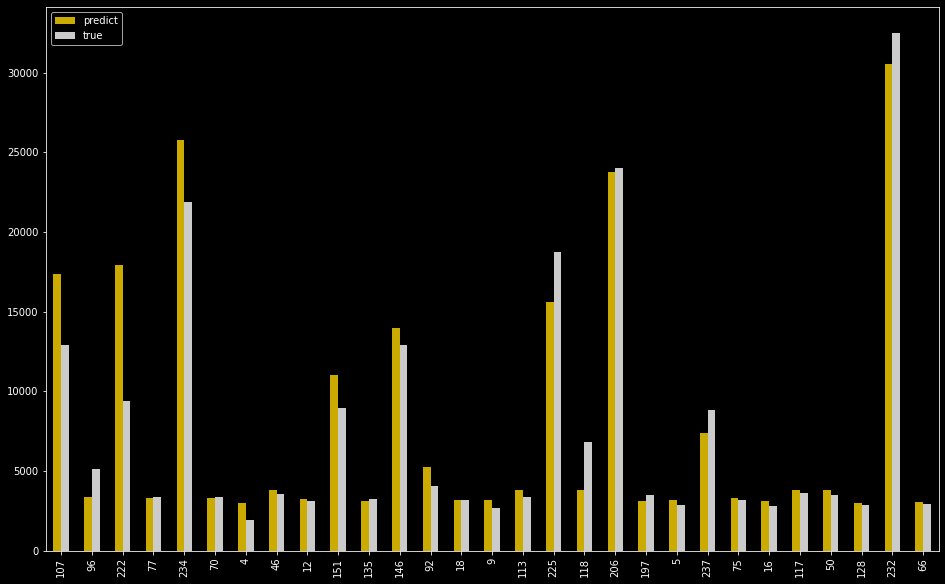

In [35]:
cntnrn = [[0.2,0.4,0.5],[0.4,0.6,0.8],[0.6,0.7,0.8],[0.5,0.5,0],[0.2,0,0.2]]


top_cntnrn_4 = None
top_epoch_4 = None
top_rmse_4 = 150000
top_preds_4 = None
top_batch_4 = None

for dnc in cntnrn:
    class Net(nn.Module):
        def __init__(self,n_in_neurons,n_hidden_neurons_1,
                    n_hidden_neurons_2,n_hidden_neurons_3,n_out_neurons):
            super(Net,self).__init__()

            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
            self.dp1 = nn.Dropout(p=dnc[0])

            self.fc2 = nn.Linear(n_hidden_neurons_1,n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            self.bn2 = nn.BatchNorm1d(n_hidden_neurons_2)
            self.dp2 = nn.Dropout(p=dnc[1])

            self.fc3 = nn.Linear(n_hidden_neurons_2,n_hidden_neurons_3)
            self.act3 = nn.ReLU()
            self.bn3 = nn.BatchNorm1d(n_hidden_neurons_3)
            self.dp3 = nn.Dropout(p=dnc[2])


            self.fc4 = nn.Linear(n_hidden_neurons_3,n_out_neurons)


            nn.init.kaiming_uniform_(self.fc1.weight, mode = 'fan_out', nonlinearity = 'relu')
            nn.init.uniform_(self.fc1.bias, a = 0.5, b = 0.7)

            nn.init.kaiming_uniform_(self.fc2.weight, mode = 'fan_out', nonlinearity = 'relu')
            nn.init.uniform_(self.fc2.bias, a = 0.5, b = 0.7)

            nn.init.kaiming_uniform_(self.fc3.weight, mode = 'fan_out', nonlinearity = 'relu')
            nn.init.uniform_(self.fc3.bias, a = 0.5, b = 0.7)

            nn.init.uniform_(self.fc4.weight, a = 0.5, b = 0.7)
            nn.init.uniform_(self.fc4.bias, a = 0.5, b = 0.7)

        def forward(self,x):
            x = self.fc1(x)
            x = self.bn1(x)
            x = self.act1(x)
            x = self.dp1(x)

            x = self.fc2(x)
            x = self.bn2(x)
            x = self.act2(x)
            x = self.dp2(x)

            x = self.fc3(x)
            x = self.bn3(x)
            x = self.act3(x)
            x = self.dp3(x)

            x = self.fc4(x)

            return x
        

    n_in_neurons = 10
    n_hidden_neurons_1 = 24
    n_hidden_neurons_2 = 12
    n_hidden_neurons_3 = 6
    n_out_neurons = 1

    net = Net(10,24,12,6,1)

    optimizer = torch.optim.Adam(net.parameters(), lr = 0.10)

    loss = nn.MSELoss()

    num_epochs = 2000


    batch_size = [5,10,20,40,50,100]
    for btch in batch_size:

        num_batches = ceil(len(x_train)/btch)
        for epoch in range(num_epochs):

            order = np.random.permutation(len(x_train))

            for batch_idx in range(num_batches):
                start_index = batch_idx * btch
                optimizer.zero_grad()
                batch_indexes = order[start_index:start_index + btch]
                x_batch = x_train[batch_indexes]
                y_batch = y_train[batch_indexes]
                preds = net.forward(x_batch).flatten()
                loss_value = loss(preds, y_batch)
                loss_value.backward()
                optimizer.step()
                
            if epoch % 5 == 0 or epoch == num_epochs -1:
                net.eval()
                test_preds = net.forward(x_test)
                rmse = sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy()))
            if epoch % 200 == 0 or epoch == num_epochs -1:
                if rmse < top_rmse_4:
                    top_rmse_4 = rmse
                    top_epoch_4 = epoch
                    top_preds_4 = test_preds
                    top_cntnrn_4 = dnc
                    top_batch_4 = btch
            if epoch % 200 == 0 or epoch == num_epochs -1:
                print(f'Step: {epoch}, Drop: {dnc}, batch: {btch} ,RMSE:',rmse)


print(f'top rmse: {top_rmse_4}','\n'
             , f'top epoch: {top_epoch_4}','\n',
     f'top drop {top_cntnrn_4}','\n',
     f'top batch {top_batch_4}')
compar(top_preds_4, y_test, y_idx)

Попытка использования BatchNormalization & Dropout, как и обычное обучение по батчам не оправдывает своё использование.

### Подготовка итоговой нейронной сети:

1. Опираясь на результативность метода Dropout - напишем итоговую архитектуру нейронной сети
2. Ввиду случайного характера отключения нейронов - создадим цикл, который будет перезапускать нейронную сеть, до получения эффективног результата
3. Остановим цикл на пороге метрики RMSE менее 3000 как для TEST, так и для TRAIN, чтобы избажать случайной подгонки под одну лишь тестовую выборку.


In [36]:
"""
\\\\\
Переопределим выбранный нами класс последний раз,
указав параметры Dropout
/////
"""


class Net(nn.Module):
    def __init__(self,n_in_neurons,n_hidden_neurons_1,
                    n_hidden_neurons_2,n_hidden_neurons_3,n_out_neurons):
        super(Net,self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.act1 = nn.ReLU()
        self.dp1 = nn.Dropout(p= 0.4)

        self.fc2 = nn.Linear(n_hidden_neurons_1,n_hidden_neurons_2)
        self.act2 = nn.ReLU()
        self.dp2 = nn.Dropout(p = 0.6)

        self.fc3 = nn.Linear(n_hidden_neurons_2,n_hidden_neurons_3)
        self.act3 = nn.ReLU()
        self.dp3 = nn.Dropout(p = 0.8)

        self.fc4 = nn.Linear(n_hidden_neurons_3,n_out_neurons)

        nn.init.kaiming_uniform_(self.fc1.weight, mode = 'fan_out', nonlinearity = 'relu')
        nn.init.uniform_(self.fc1.bias, a = 0.5, b = 0.7)


        nn.init.kaiming_uniform_(self.fc2.weight, mode = 'fan_out', nonlinearity = 'relu')
        nn.init.uniform_(self.fc2.bias, a = 0.5, b = 0.7)

        nn.init.kaiming_uniform_(self.fc3.weight, mode = 'fan_out', nonlinearity = 'relu')
        nn.init.uniform_(self.fc3.bias, a = 0.5, b = 0.7)

        nn.init.uniform_(self.fc4.weight, a = 0.5, b = 0.7)
        nn.init.uniform_(self.fc4.bias, a = 0.5, b = 0.7)

    def forward(self,x):

        x = self.fc1(x)
        x = self.act1(x)
        x = self.dp1(x)

        x = self.fc2(x)
        x = self.act2(x)
        x = self.dp2(x)

        x = self.fc3(x)
        x = self.act3(x)
        x = self.dp3(x)

        x = self.fc4(x)
        return x
    
        

Создадим цикл, который будет перезапускать класс нейронной сети до тех пор, пока не будет инициализированна наилучшая сессия с близкой к уже имевшейся точности RMSE, но в этот раз и по тренировочной выборке, чтобы избежать случайной подгонки теста.

In [43]:
n_in_neurons = 10
n_hidden_neurons_1 = 24
n_hidden_neurons_2 = 12
n_hidden_neurons_3 = 6
n_out_neurons = 1


k = 0


for c in range(1667):
    net = Net(10,24,12,6,1)
    optimizer = torch.optim.Adam(net.parameters(), lr = 0.10 )
    loss = nn.MSELoss()
    print('start new_cycle')
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        preds = net.forward(x_train).flatten()
        loss_value = loss(preds, y_train)
        loss_value.backward()
        optimizer.step()


        net.eval()
        test_preds = net.forward(x_test)
        train_preds = net.forward(x_train)
        rmse_5 = sqrt(mean_squared_error(y_test.detach().numpy(), test_preds.detach().numpy()))    
        train_rmse = sqrt(mean_squared_error(y_train.detach().numpy(), train_preds.detach().numpy()))  
        if rmse_5 < 3075 and train_rmse < 3075:
            k +=1
            break
        if epoch % 100 == 0 or epoch == num_epochs -1:
            print(f'Цикл: {c+1}, Эпоха: {epoch}, RMSE test: {rmse_5}, RMSE train {train_rmse}')
    if k > 0:
        torch.save(net.state_dict(), '3000RMSE_pth')
        break

start new_cycle
Цикл: 1, Эпоха: 0, RMSE test: 11383.994729443615, RMSE train 14967.272563830726
Цикл: 1, Эпоха: 100, RMSE test: 5703.947580404294, RMSE train 5094.958292272862
Цикл: 1, Эпоха: 200, RMSE test: 4796.368209385097, RMSE train 4071.820600173834
Цикл: 1, Эпоха: 300, RMSE test: 4402.949011742016, RMSE train 3858.051969582577
Цикл: 1, Эпоха: 400, RMSE test: 3999.30781511001, RMSE train 3677.31151794351
Цикл: 1, Эпоха: 500, RMSE test: 3664.720180313908, RMSE train 3544.877148788093
Цикл: 1, Эпоха: 600, RMSE test: 3415.4389176209843, RMSE train 3488.044867830688
Цикл: 1, Эпоха: 700, RMSE test: 3291.6012820510323, RMSE train 3440.4982197350428
Цикл: 1, Эпоха: 800, RMSE test: 3297.9619464147854, RMSE train 3161.478609764741
Цикл: 1, Эпоха: 900, RMSE test: 3212.733260013971, RMSE train 3121.8811636575792
Цикл: 1, Эпоха: 1000, RMSE test: 3347.2500653521543, RMSE train 3054.8436948557614
Цикл: 1, Эпоха: 1100, RMSE test: 3338.1172837394433, RMSE train 2984.332253620565
Цикл: 1, Эпоха: 

In [44]:
print(f'Обнаружен кандидат с точностью  на тесте RMSE:{rmse_5}, Точность на трейне RMSE:{train_rmse}')

Обнаружен кандидат с точностью  на тесте RMSE:3058.9936253611254, Точность на трейне RMSE:2972.6025634113957


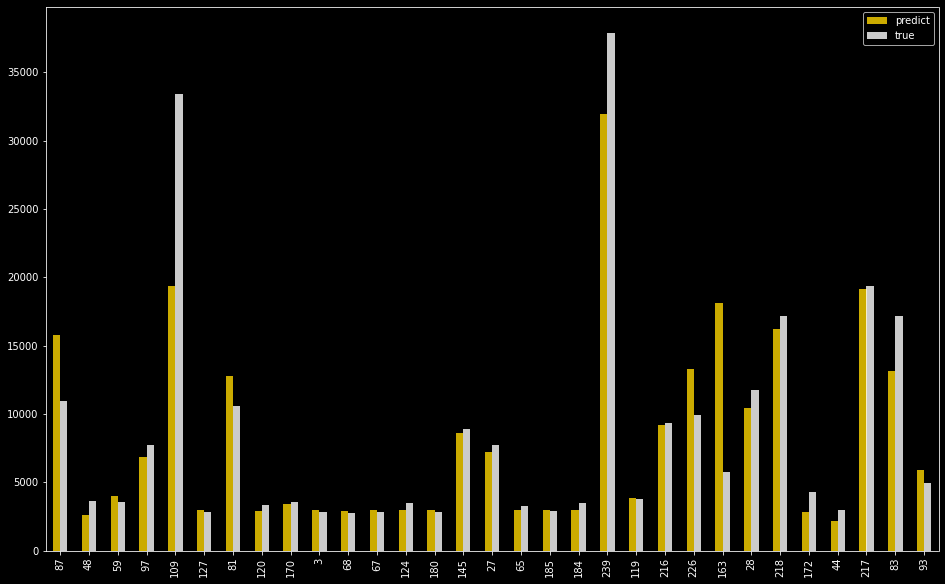

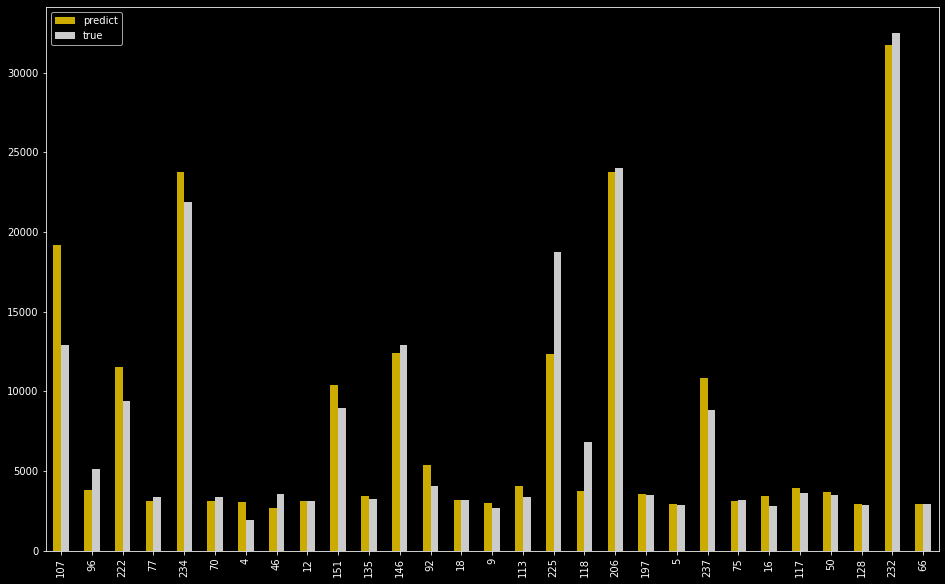

In [45]:
compar(test_preds, y_test, y_idx)

### Вывод по результатам  улучшения нейронной сети

In [46]:
pd.DataFrame({'Type':['Static','BatchNormalization','Dropout','BatchNormalization & Dropout'],'top RMSE':['3088','3860','3058','3257']})

,Type,top RMSE
0,Static,3088
1,BatchNormalization,3860
2,Dropout,3058
3,BatchNormalization & Dropout,3257


В полученных результатах большую роль сыграла архитектура нейронной сети, которая позволила практически в любых обстоятельствах дойти до точности лучше пороговой.


Большую роль для улучшения сети сыграл Dropout с большими весовыми коэффицентами. Метод усложнил и как следствие сильно улучшийл итоговоую точность нейронной сети.

Наименее результативным стало обучение, использующее выборки. Что может так выглядить ввиду немногочисленных данных и отсутствии возможности их агументации без помощи специалиста.

## Итоги по проекту:

Была разработана нейронная сеть для определения температуры на поверхности обнаруженных звезд.
* Показатель RMSE для базовой модели составил 3088:
    * Базовая модель состоит из:
    
    
        1. Входной слой  из 10 признаков
        2. Первый скрытый слой из 24 нейронов и функции активации ReLU()
        3. Второй скрытый слой из 16 нейронов и функции фктивации ReLU()
        4. Третий скрытый слой из 12 нейронов и функции активации ReLU()
        5. Выходнйо слой из 1 нейрона с линейной функцией активации
        
        
* Показатель RMSE для модели, использующей BatchNormalization, составил: 3860
    1. Лучший размер батча: 10
    
    
* Показатель RMSЕ для модели, улучшенной с помощью Dropout, составил: 3098
    * Лучшие веса для dropout: 
            1. 0.4 на скрытый слой 1
            2. 0.6 на скрытый слой 2
            3. 0.8 на скрытый слой 3
        
        
* Показатель RMSE для модели, использующей BatchNormalization и Dropout, составил: 3257
    * Лучшие веса для dropout:
        
            1. 0.2 на скрытый слой 1
            2. 0.4 на скрытый слой 2
            3. 0.5 на скрытый слой 3

    * Лучший размер батча: 50


    
Оптимизация всех моделей превысили проходную планку в 4500 RMSE.

  * **Из представленных моделей итоговой выбрана модель с Dropout достигшая в итоговом тесте:**
   
    **3058 RMSE на тестовой выборке и 2972 RMSE на тренировочной.**



Для построения моделей:
* были изменены данные категориальных признаков в эквивалетные числовые и бинарно-строковые 
* была проведена стандартизация данных, для большего подобия в размерах